# Introduction

Here is a summary of what was tested in the former part of this
document:

* In the first part, we defined the average costs of static
  tracepoints (about 350ns) and dynamic probes (about 400ns);
* In the second part, we had a look at costs distributions (1% of the
  samples are beyond the double of the average value);
* In the third part, we tried to find out why the costs were so high
  (275ns are due to events serializations into the ring-buffers).

In this fourth part, we will try to skip the ring-buffers; we will
test eBPF programs attached to dynamic probes and we will estimate
their costs.

# Description of the test environment

All the tests will be executed in the same environment (and nearly the
same as before):

*Basic laptop machine*

* CPU: Intel Core i7-3537U @ 2.00GHz (up to 3.10GHz) 1 CPU / 2 cores
  per CPU / 2 threads per core;
* RAM: 8GB;
* System: Arch (linux-4.5.4.1, glibc-2.23)
* Cpufreq governor: performance: the pstate power scaling driver is
  used; so the CPU frequency cannot be statically set with a
  user-space tool.
```
# cpupower frequency-set -g performance
```

The difference between the former test environments is the Linux
kernel version; it was upgraded (4.4 -> 4.5).

# Step 1: Testing eBPF programs thanks to the project bcc

We decided to use the library [bcc](https://github.com/iovisor/bcc) and
its associated scripts so as to test the eBPF features.

Starting from the script "softirqs.py", a small BPF program was
written so as to record delays between 2 events.

Here is the code:
```
#include <uapi/linux/ptrace.h>

typedef struct irq_key {
    u64 ip;
    u64 slot;
} irq_key_t;
BPF_HASH(start, u32);

BPF_HISTOGRAM(dist, irq_key_t);

int trace_func(struct pt_regs *ctx)
{
    u32 pid = bpf_get_current_pid_tgid();
    u64 *tsp, delta, ts = bpf_ktime_get_ns();

    tsp = start.lookup(&pid);
    if (tsp != 0) {
        u64 delta = ts - *tsp;
        irq_key_t key = {.ip = 0, .slot = bpf_log2l(delta)};
        dist.increment(key);
    }

    start.update(&pid, &ts);

    return 0;
}
```

The full python script "delay.py" holding the BPF program is available
in annex A.

Once we got a fully fonctional BPF callback attached to the dynamic
probes kprobe:sys_read and kprobe:sys_write, let's reus the "dd"
benchmark scenario:
```
$ time dd if=/dev/zero of=/dev/null bs=1
```

And we compared the results (the execution times) with the cases
already tested:

* "dd" execution times without any dynamic probes;
* "dd" execution times with dynamic probes enabled.

The bcc scripts seems to have some issues with static tracepoints
(unable to use a static tracepoint if the corresponding tracing code
has been inlined); that is why dynamic probes were used instead.

## Results

The benchmarks raw ouput lines are available in the annex B. Here, the
reader will only find a graphic summarizing the execution times.

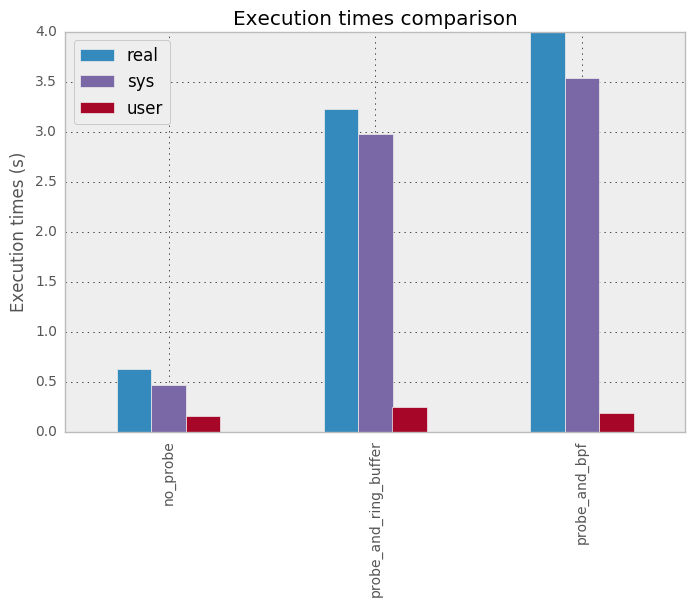

In [5]:
no_probe = {'real': 0.625, 'user': 0.157, 'sys': 0.463}
probe_and_rng_buf = {'real': 3.227, 'user': 0.247, 'sys': 2.977}
probe_and_bpf = {'real': 3.997, 'user': 0.183, 'sys': 3.537}
names = ['no_probe', 'probe_and_ring_buffer', 'probe_and_bpf']
time_df = pd.DataFrame([no_probe, probe_and_rng_buf, probe_and_bpf], index=names)


# ...to make a simple bar plot
plot = time_df.plot(kind='bar', figsize=(8, 5))
plot.set_ylabel('Execution times (s)')
plot.set_title('Execution times comparison')

## Interpretation

The bar-plot above clearly shows that the cost of a bpf program which
uses 2 hash tables is higher than the cost of serializing the probe
events into a ring-buffer.

The average cost of a unitary execution of the bpf program associated
to a probe reaches 500ns (516ns precisely) against 400ns (event 434ns
in this test) for the serialization of a probe event into the ring
buffer.

The next step is to find out why the BPF program is so expensive

# Step 2: profiling eBPF program executions

In this chapter, we profile the system during 10s (a "dd" command was
running during the whole period and probes associated to BFP were
enabled).

## Results

```
# perf record -a -g -o callstack.data -- sleep 10
# perf report -i callstack.data | less
...
# Children      Self  Command          Shared Object               Symbol
# ........  ........  ...............  ..........................  ..............................................
#
    84.92%     0.54%  dd               [kernel.vmlinux]            [k] entry_SYSCALL_64_fastpath
                         |
                         |--84.37%--entry_SYSCALL_64_fastpath
                         |          |
                         |          |--42.85%--sys_read
                         |          |          |
                         |          |          |--35.95%--0x6145
                         |          |          |          |
                         |          |          |          |--35.80%--ftrace_ops_assist_func
                         |          |          |          |          |
                         |          |          |          |          |--34.92%--kprobe_ftrace_handler
                         |          |          |          |          |          |
                         |          |          |          |          |          |--34.15%--kprobe_dispatcher
                         |          |          |          |          |          |          |
                         |          |          |          |          |          |          |--33.82%--kprobe_perf_func
                         |          |          |          |          |          |          |          |
                         |          |          |          |          |          |          |          |--33.53%--trace_call_bpf
                         |          |          |          |          |          |          |          |          |
                         |          |          |          |          |          |          |          |          |--31.56%--__bpf_prog_run
                         |          |          |          |          |          |          |          |          |          |
                         |          |          |          |          |          |          |          |          |          |--15.07%--bpf_map_update_elem
                         |          |          |          |          |          |          |          |          |          |          |
                         |          |          |          |          |          |          |          |          |          |          |--13.67%--htab_map_update_elem
...
                         |          |          |          |          |          |          |          |          |          |--3.63%--bpf_map_lookup_elem
...
                         |          |          |          |          |          |          |          |          |          |--0.56%--bpf_ktime_get_ns
                         |          |          |          |          |          |          |          |          |          |--0.10%--htab_map_update_elem
                         |          |          |          |          |          |          |          |          |          |
                         |          |          |          |          |          |          |          |          |          |--0.07%--nmi
                         |          |          |          |          |          |          |          |          |          |
                         |          |          |          |          |          |          |          |          |          |--0.05%--bpf_get_current_pid_tgid
                         |          |          |          |          |          |          |          |          |          |
                         |          |          |          |          |          |          |          |          |          |--0.04%--htab_map_lookup_elem
```

## Interpretation

The "perf report" output above only shows the callstack behind
sys_read (there is the same callstack after sys_write).

The execution of the BPF program accumulates most of the samples
(31.56% of 42.85% for __bpf_prog_run).

And inside the BPF routine, the manipulation of hash table(s) is the
most expensive part (bpf_map_update_elem and
bpf_map_lookup_elem). Hash tables are declared using macros like
BPF_HISTOGRAM and BPF_HASH.

It might be interesting to perform some simple tests so as to isolate
the cost of some BPF-related operations.

# Step 3: evaluating costs of BPF code

In this third chapter, the goal is to get numbers for some BPF-related
operations:

* Lookup and update of a histogram (declared with BPF_HISTOGRAM, which
  is in fact a hash table));
* Lookup and update of a second hash table (declared with BPF_HASH)
* Call an empty BPF function;

We will reuse the BFP code presented in the first part and disable its
content step by step. each measured gain after having removed an
operation will be the estimated cost of this operation.

The various versions of BPF code and the corresponding "dd" execution
times are available in annex C.

## Results

Thanks to the tests detailed in annex C, the costs of the following
operations were calculated:

* Lookup and update of a bcc histogram: 262ns;
* Lookup and update of a bcc hash table: 183ns;
* BPF callback overhead: 58ns;

It is suprising to notice that the cost of the update of the histogram
( which is also a hash table) is higher (by 30%) than the cost for the
2nd the hash table manipulation.

The following reasons might explain it:

* The key of the histogram is wider (64 bits) than the key of the
  second one (32 bits);
* The histogram only contains 64 buckets and the 2nd hash table
  displays 10240 buckets; there might be more collisions in the
  histogram;
 

# Conclusion

With BPF programs, the user must take great care in the implementation
of the BPF callback routine if he does not want to alter the monitored
environment; using 2 hash tables in some BPF code will be more
expensive than simply dumping all the probe / tracepoint events into
user-space.


# Annex A: delay.py python script

```
from __future__ import print_function
from bcc import BPF
from time import sleep, strftime

# Define BPF program
bpf_text = """
#include <uapi/linux/ptrace.h>

typedef struct irq_key {
    u64 ip;
    u64 slot;
} irq_key_t;
BPF_HASH(start, u32);

BPF_HISTOGRAM(dist, irq_key_t);

int trace_func(struct pt_regs *ctx)
{
    u32 pid = bpf_get_current_pid_tgid();
    u64 *tsp, delta, ts = bpf_ktime_get_ns();

    tsp = start.lookup(&pid);
    if (tsp != 0) {
        u64 delta = ts - *tsp;
        irq_key_t key = {.ip = 0, .slot = bpf_log2l(delta)};
        dist.increment(key);
    }

    start.update(&pid, &ts);

    return 0;
}
"""

# Load BPF program
b = BPF(text=bpf_text)

# Attach the probes on the BPF program
for sysfunc in ('sys_read', 'sys_write'):
    b.attach_kprobe(event=sysfunc, fn_name='trace_func')

print('Calculating delays btw sys_read and sys_write ... Hit Ctrl-C to end.')

dist = b.get_table("dist")
try:
    sleep(99999999)
except KeyboardInterrupt:
    pass

# Output
dist.print_log2_hist("usecs", "delay")
dist.clear()
```

# Annex B: dd benchmarks raw output

## Without dynamic probes

```
$ time dd if=/dev/zero of=/dev/null bs=1
count=3000000
3000000+0 records in
3000000+0 records out
3000000 bytes (3.0 MB, 2.9 MiB) copied, 0.623472 s, 4.8 MB/s

real    0m0.625s
user    0m0.157s
sys     0m0.463s
```

## With dynamic probes but without BPF

```
$ sudo perf record -e probe:sys_read -e
probe:sys_write -- bash -c "time dd if=/dev/zero of=/dev/null bs=1
count=3000000"3000000+0 records in
3000000+0 records out
3000000 bytes (3.0 MB, 2.9 MiB) copied, 3.22665 s, 930 kB/s

real    0m3.227s
user    0m0.247s
sys     0m2.977s
[ perf record: Woken up 533 times to write data ]
[ perf record: Captured and wrote 480.925 MB perf.data (6000029
samples) ]
```

## With dynamic probes and BPF

*Output of dd command*:

```
$ time dd if=/dev/zero of=/dev/null bs=1
count=3000000
3000000+0 records in
3000000+0 records out
3000000 bytes (3.0 MB, 2.9 MiB) copied, 3.99611 s, 751 kB/s

real    0m3.997s
user    0m0.183s
sys     0m3.537s
```

*Output of python script delay.py giving the histogram of the delays
 between 2 probe events*:
 
```
test.py output:
               usecs                         : count     distribution
                   0 -> 1                    : 0        |                    |
                   2 -> 3                    : 0        |                    |
                   4 -> 7                    : 0        |                    |
                   8 -> 15                   : 0        |                    |
                  16 -> 31                   : 0        |                    |
                  32 -> 63                   : 0        |                    |
                  64 -> 127                  : 0        |                    |
                 128 -> 255                  : 0        |                    |
                 256 -> 511                  : 0        |                    |
                 512 -> 1023                 : 5925702  |********************|
                1024 -> 2047                 : 70196    |                    |
                2048 -> 4095                 : 1376     |                    |
                4096 -> 8191                 : 1187     |                    |
                8192 -> 16383                : 3612     |                    |
               16384 -> 32767                : 962      |                    |
               32768 -> 65535                : 799      |                    |
               65536 -> 131071               : 927      |                    |
              131072 -> 262143               : 954      |                    |
              262144 -> 524287               : 565      |                    |
              524288 -> 1048575              : 137      |                    |
             1048576 -> 2097151              : 21       |                    |
             2097152 -> 4194303              : 27       |                    |
             4194304 -> 8388607              : 73       |                    |
             8388608 -> 16777215             : 151      |                    |
            16777216 -> 33554431             : 174      |                    |
            33554432 -> 67108863             : 180      |                    |
            67108864 -> 134217727            : 320      |                    |
           134217728 -> 268435455            : 6        |                    |
           268435456 -> 536870911            : 3        |                    |
           536870912 -> 1073741823           : 2        |                    |
          1073741824 -> 2147483647           : 6        |                    |
          2147483648 -> 4294967295           : 4        |                    |
          4294967296 -> 8589934591           : 3        |                    |
```

# Annex C: the costs of some BPF tools / operations

## First BPF code: nothing disabled

This version is not the one used in annex C, the key of the histogram
was simplified: the struct composed of 2 u64 fields was just replaced
by a mere u64 field:

```
#include <uapi/linux/ptrace.h>

BPF_HASH(start, u32);
BPF_HISTOGRAM(dist, u64);

int trace_func(struct pt_regs *ctx)
{
    u32 pid = bpf_get_current_pid_tgid();
    u64 *tsp, delta, ts = bpf_ktime_get_ns();

    tsp = start.lookup(&pid);
    if (tsp != 0) {
        u64 delta = ts - *tsp;
        u64 slot = bpf_log2l(delta);
        dist.increment(slot);
    }

    start.update(&pid, &ts);

    return 0;
}
```

Here are the associated "dd" execution times:

```
$ time dd if=/dev/zero of=/dev/null bs=1
count=3000000
3000000+0 records in
3000000+0 records out
3000000 bytes (3.0 MB, 2.9 MiB) copied, 3.92387 s, 765 kB/s

real    0m3.925s
user    0m0.180s
sys     0m3.480s

```

## BPF code without any BPF histogram (or map) used

```
#include <uapi/linux/ptrace.h>

BPF_HASH(start, u32);
BPF_HISTOGRAM(dist, u64);

int trace_func(struct pt_regs *ctx)
{
    u32 pid = bpf_get_current_pid_tgid();
    u64 *tsp, ts = bpf_ktime_get_ns();

    tsp = start.lookup(&pid);
    if (tsp != 0) {
        ts -= *tsp;
    }

    start.update(&pid, &ts);

    return 0;
}
```

Here are the associated "dd" execution times:

```
$ time dd if=/dev/zero of=/dev/null bs=1
count=3000000
3000000+0 records in
3000000+0 records out
3000000 bytes (3.0 MB, 2.9 MiB) copied, 2.35214 s, 1.3 MB/s

real    0m2.353s
user    0m0.180s
sys     0m1.907s
```

## BPF code without any BPF hash table used

```
#include <uapi/linux/ptrace.h>

BPF_HASH(start, u32);
BPF_HISTOGRAM(dist, u64);

int trace_func(struct pt_regs *ctx)
{
    return 0;
}
```

Here are the associated "dd" execution times:

```
$ time dd if=/dev/zero of=/dev/null bs=1
count=3000000
3000000+0 records in
3000000+0 records out
3000000 bytes (3.0 MB, 2.9 MiB) copied, 0.970007 s, 3.1 MB/s

real    0m0.971s
user    0m0.160s
sys     0m0.810s
```

## Without dynamic probes

```
$ time dd if=/dev/zero of=/dev/null bs=1
count=3000000
3000000+0 records in
3000000+0 records out
3000000 bytes (3.0 MB, 2.9 MiB) copied, 0.623472 s, 4.8 MB/s

real    0m0.625s
user    0m0.157s
sys     0m0.463s

# Annex D: pre-requisite import python code

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

# Use default pandas plot theme
pd.options.display.mpl_style = 'default'

# Additional Matplotlib stuff
mpl.rcParams['font.size'] = 10
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.subplot.bottom'] = .1